# Project 4: Predict West Nile Virus
### Section 5. Model Exploration

## Problem Statement

1. As an employee of Disease And Treatment Agency, division of Societal Cures In Epidemiology and New Creative Engineering (DATA-SCIENCE), we are tasked to better understand the mosquito population and advise on appropriate interventions which are beneficial and cost-effective for the city.


2. Through this project, we hope to:
- Identify features which are most important to predict presence of West Nile Virus (which can be done by ranking the coefficients of each feature in a logistic regression model)
- Predict the probability of West Nile Virus by location to provide decision makers an effective plan to deploy pesticides throughout the city, which consequently can help to reduce cost.

## Import Libraries

In [322]:
#!pip install shapely
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
# from shapely import geometry
# from shapely.geometry import Point, Polygon
# import geopandas as gpd
# from datetime import timedelta
# import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, classification_report, 
                             plot_roc_curve, roc_auc_score, accuracy_score, precision_score, 
                             recall_score, f1_score) #precision_recall_curve
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

## Load Data

In [323]:
# Load datasets
df = pd.read_csv('../data/final_df.csv', index_col='Unnamed: 0')

### Split into train and test (Kaggle) data

In [324]:
# Split into train and test (kaggle) data 
train = df[df['dataset']=='train'].copy()
test = df[df['dataset']=='test'].copy()
print(train.shape)
print(test.shape)

(8304, 240)
(43035, 240)


In [325]:
train.drop(columns='dataset', inplace=True)
test.drop(columns='dataset', inplace=True)

In [326]:
train.describe()

,latitude,longitude,tavg,preciptotal,stnpressure,resultdir,avgspeed,is_spray,stnpressure_7,stnpressure_10,...,codesum_TSRA BR HZ VCTS,codesum_TSRA FG+ BR HZ,codesum_TSRA RA,codesum_TSRA RA BR,codesum_TSRA RA BR HZ,codesum_TSRA RA BR HZ VCTS,codesum_TSRA RA BR VCTS,codesum_TSRA RA VCTS,codesum_VCTS,wnvpresent
count,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,8304.000000,...,8304.000000,8304.0,8304.000000,8304.000000,8304.0,8304.0,8304.000000,8304.0,8304.000000,8304.000000
mean,41.845800,-87.696229,72.093931,0.182431,29.262110,17.842245,7.476903,0.008911,29.277200,29.265990,...,0.006142,0.0,0.029383,0.037211,0.0,0.0,0.010597,0.0,0.003974,0.055034
std,0.106658,0.084440,7.630330,0.470450,0.118606,9.433945,2.543438,0.093984,0.126573,0.142227,...,0.078132,0.0,0.168889,0.189290,0.0,0.0,0.102402,0.0,0.062918,0.228060
min,41.644612,-87.930995,50.000000,0.000000,28.890000,1.000000,2.100000,0.000000,28.890000,28.910000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
25%,41.750498,-87.752411,69.000000,0.000000,29.180000,8.000000,5.800000,0.000000,29.210000,29.180000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
50%,41.862292,-87.696269,73.000000,0.000000,29.260000,19.000000,7.100000,0.000000,29.280000,29.260000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
75%,41.947227,-87.648064,78.000000,0.160000,29.340000,25.000000,9.400000,0.000000,29.380000,29.360000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
max,42.017430,-87.531635,87.000000,3.970000,29.650000,36.000000,16.300000,1.000000,29.650000,29.650000,...,1.000000,0.0,1.000000,1.000000,0.0,0.0,1.000000,0.0,1.000000,1.000000


In [327]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8304 entries, 0 to 8303
Columns: 239 entries, latitude to wnvpresent
dtypes: float64(11), int64(228)
memory usage: 15.2 MB


### Further Split Train Data into Train and Holdout

In [328]:
# Split train data into X (all features except wnvpresent) and y (wnvpresent)
features = [col for col in train.columns if col != 'wnvpresent']
X = train[features]
y = train['wnvpresent']

In [329]:
X.columns[X.isna().any()].tolist()

[]

In [330]:
y.value_counts(normalize = True)

0.0    0.944966
1.0    0.055034
Name: wnvpresent, dtype: float64

- "wnvpresent"'s presence is highly inbalanced, with only about 5.5% of the data points having West Nile Virus. 
    - It is important to stratify proportionally to ensure that our train and holdout dataset have about the same proportion of presence and absence of West Nile Virus.
    - We might also need to use SMOTE as the accuracy of our models without SMOTE might be close to the proportion of absence of WNV). We will ascertain this using logistic regression below.

In [331]:
# Further split train data into train and holdout data
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, 
    y,
    stratify = y,
    random_state=42
)

In [332]:
# Scale our data
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_holdout = ss.transform(X_holdout)

## Create synthetic data with SMOTE

In [333]:
# create synthetic data for train set
sm = SMOTE()
Xsm_train, ysm_train = sm.fit_resample(Xs_train, y_train)

In [334]:
Xsm_train.shape

(11770, 238)

## Model Exploration

### Metrics to Evaluate Models

In [335]:
# Creating a summary dataframe.
summary_df = pd.DataFrame(columns=[
    'model', 
    'best_score', 
    'train_score',
    'holdout_score',
    'sensitivity',
    'specificity',
    'precision',
    'f1_score',
    'best_params', 
])

In [336]:
summary_df

,model,best_score,train_score,holdout_score,sensitivity,specificity,precision,f1_score,best_params


In [337]:
def model_metrics(gs, X_train, y_train, X_test, y_test, modelname):
    '''Generates confusion matrix and adds scores to summary_df'''
    
    #Generate confusion matrix
    y_pred = gs.predict(X_test)
    confusion_matrix(y_test, # True values.
                     y_pred)  # Predicted values.
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel();
    y_train_pred_prob = gs.predict_proba(X_train)[:,1]
    y_test_pred_prob = gs.predict_proba(X_test)[:,1]
    
    summary_df_rows = summary_df.shape[0]
    # Adding the scores into summary_df
    summary_df.loc[summary_df_rows] = [
        modelname,
        #'CountVec/LogisticRegression',
        round(gs.best_score_, 3),
        round(metrics.roc_auc_score(y_train, y_train_pred_prob),3),
        round(metrics.roc_auc_score(y_test, y_test_pred_prob),3),
        round(metrics.recall_score(y_test, y_pred),3),
        round(tn/(tn+fp),3),
        round(tp / (tp + fp), 3),
        round(metrics.f1_score(y_test, y_pred),3),
        str(gs.best_params_),
    ]
    
    
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', 
                          display_labels=['WNV Present', 'WNV Not Present'],
                          normalize='true');  
    plt.title(label=modelname, fontsize=14)
    plt.grid(False)

### Checking for the importance of using SMOTE

We realize that the positive value of interest, WNV, only appears in about 5.5% of our dataset, there might not be enough true positives to train our modelling. We will therefore use SMOTE , Synthetic Minority Oversampling TEchnique to attempt to overcome this deficit, and will be testing this with logistic regression.

### Basic Logistic Regression w/o SMOTE

In [338]:
# Instantiate model
logreg_no_smote = LogisticRegression(max_iter = 10_000)

# Fit model
logreg_no_smote.fit(Xs_train, y_train)

print(f'Logistic Regression Intercept: {logreg.intercept_}')

Logistic Regression Intercept: [-5.18314255]


In [339]:
logreg_no_smote.score(Xs_train, y_train), logreg_no_smote.score(Xs_holdout, y_holdout)

(0.9449261400128453, 0.9436416184971098)

In [340]:
# Summary scores of CountVectorizer and LogisticRegression.
print("LogisticRegression summary of accuracy scores:")
#print(f"GridSearchCV best accuracy = {round(gs_pipe.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(logreg.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(logreg.score(X_holdout, y_holdout), 3)}")

LogisticRegression summary of accuracy scores:

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.055
Testing corpus accuracy = 0.055


C:\Users\Asus\anaconda3\envs\dsi\envs\dsi27tf\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
C:\Users\Asus\anaconda3\envs\dsi\envs\dsi27tf\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Creating model metrics specifically for log reg as it does not have some attributes such as "best score"

In [341]:
def model_metrics_logreg(gs, X_train, y_train, X_test, y_test, modelname):
    '''Generates scores and add to summary_df'''
    y_pred = gs.predict(X_test)
    
    summary_df_rows = summary_df.shape[0]
    summary_df.loc[summary_df_rows] = [
    modelname,
    '',
    round(gs.score(X_train, y_train), 3),
    round(gs.score(X_test, y_test), 3),
    # round(metrics.roc_auc_score(y_train, y_train_pred_prob),3),
    # round(metrics.roc_auc_score(y_test, y_test_pred_prob),3),
    round(metrics.recall_score(y_test, y_pred),3),
    round(tn/(tn+fp),3),
    round(tp / (tp + fp), 3),
    round(metrics.f1_score(y_test, y_pred),3),
    '',
]
    
        # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', 
                          display_labels=['WNV Present', 'WNV Not Present'],
                          normalize='true');  
    plt.title(label=modelname, fontsize=14)
    plt.grid(False)

In [342]:
summary_df = pd.DataFrame(columns=[
    'model', 
    'best_score', 
    'train_score',
    'holdout_score',
    'sensitivity',
    'specificity',
    'precision',
    'f1_score',
    'best_params', 
])

Model performance for no smote

C:\Users\Asus\anaconda3\envs\dsi\envs\dsi27tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


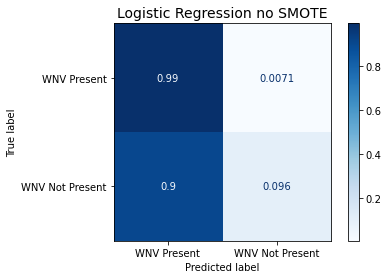

In [343]:
model_metrics_logreg(logreg_no_smote, Xs_train, y_train, Xs_holdout, y_holdout, "Logistic Regression no SMOTE")

In [344]:
summary_df

,model,best_score,train_score,holdout_score,sensitivity,specificity,precision,f1_score,best_params
0,Logistic Regression no SMOTE,,0.945,0.944,0.096,0.766,0.139,0.158,


### Basic Logistic Regression w/ SMOTE

In [345]:
# Instantiate model
logreg_smote = LogisticRegression(max_iter = 10_000)

# Fit model
logreg_smote.fit(Xsm_train, ysm_train)

print(f'Logistic Regression Intercept: {logreg_smote.intercept_}')

Logistic Regression Intercept: [-3.8873727]


In [346]:
#log-reg of with-week data, with SMOTE
logreg_smote.score(Xsm_train, ysm_train), logreg_smote.score(Xs_holdout, y_holdout)

(0.8595581988105353, 0.7885356454720617)

C:\Users\Asus\anaconda3\envs\dsi\envs\dsi27tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


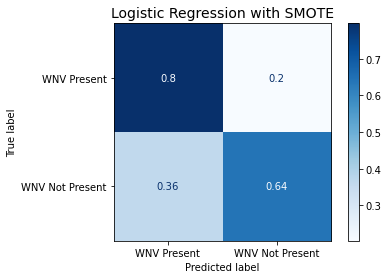

In [347]:
model_metrics_logreg(logreg_smote, Xsm_train, ysm_train, Xs_holdout, y_holdout, 
                     'Logistic Regression with SMOTE')

In [348]:
summary_df

,model,best_score,train_score,holdout_score,sensitivity,specificity,precision,f1_score,best_params
0,Logistic Regression no SMOTE,,0.945,0.944,0.096,0.766,0.139,0.158,
1,Logistic Regression with SMOTE,,0.860,0.789,0.640,0.766,0.139,0.250,


We observe that the accuracy has decreased from 0.945 to 0.860, which means that we are not predicting true positives or true negatives accurately as often. However, we observe that our sensitivity, which is our true positive over the sum of true positive and false negatives, has increased from the low value of 0.096 to 0.640. That means that roughly 64.0% of the WNV positive traps can be caught by our model, compared to about 9.44% previously. Therefore, we would prefer to use SMOTE in order to capture more WNV positive points for effective control. 

### Testing of importance of Week & Year data

Week and Year variables might just have recurring indicative weather effects, which might just be re-representing our weather data, or they might capture information that are outside of our weather data. We conducted a Log Reg to see if removing these data will cause huge differences to the model.

In [349]:
df2 = df.copy()

In [350]:
df2.drop(columns = ['week_23',
 'week_24',
 'week_25',
 'week_26',
 'week_27',
 'week_28',
 'week_29',
 'week_30',
 'week_31',
 'week_32',
 'week_33',
 'week_34',
 'week_35',
 'week_36',
 'week_37',
 'week_38',
 'week_39',
 'week_40',
 'week_41',
 'year_2008',
 'year_2009',                    
 'year_2010',                    
 'year_2011',
 'year_2012',
 'year_2013',                    
 'year_2014',                     
                   ], inplace = True)

In [351]:
df2.columns

Index(['latitude', 'longitude', 'tavg', 'preciptotal', 'stnpressure',
       'resultdir', 'avgspeed', 'is_spray', 'stnpressure_7', 'stnpressure_10',
       ...
       'codesum_TSRA FG+ BR HZ', 'codesum_TSRA RA', 'codesum_TSRA RA BR',
       'codesum_TSRA RA BR HZ', 'codesum_TSRA RA BR HZ VCTS',
       'codesum_TSRA RA BR VCTS', 'codesum_TSRA RA VCTS', 'codesum_VCTS',
       'wnvpresent', 'dataset'],
      dtype='object', length=214)

Naming this train data as train2.

In [352]:
train2 = df2[df2['dataset']=='train'].copy()
test2 = df2[df2['dataset']=='test'].copy()
print(train2.shape)
print(test2.shape)

(8304, 214)
(43035, 214)


In [353]:
# Split train data into X (all features except wnvpresent) and y (wnvpresent)
features = [col for col in train2.columns if col != 'wnvpresent']
X2 = train2[features]
y2 = train2['wnvpresent']

In [354]:
X2.drop(columns = ["dataset"],inplace = True)

C:\Users\Asus\anaconda3\envs\dsi\envs\dsi27tf\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [355]:
# Further split train data into train and holdout data
X_train2, X_holdout2, y_train2, y_holdout2 = train_test_split(
    X2, 
    y2,
    stratify = y2,
    random_state=42
)

In [356]:
# Scale our data
ss = StandardScaler()
Xs_train2 = ss.fit_transform(X_train2)
Xs_holdout2 = ss.transform(X_holdout2)

In [357]:
# create synthetic data for train set
sm = SMOTE()
Xsm_train2, ysm_train2 = sm.fit_resample(Xs_train2, y_train2)

New Smote data is Xsm_train2, ysm_train2

In [358]:
logreg_noyr_nowk = LogisticRegression(max_iter=10_000)

# Fit model
logreg_noyr_nowk.fit(Xsm_train2, ysm_train2)

print(f'Logistic Regression Intercept: {logreg_noyr_nowk .intercept_}')

Logistic Regression Intercept: [-2.45336088]


In [359]:
#logreg of no-week data, with SMOTE
logreg_noyr_nowk .score(Xsm_train2, ysm_train2), logreg_noyr_nowk.score(Xs_holdout2, y_holdout2)

(0.8282922684791844, 0.7581888246628131)

C:\Users\Asus\anaconda3\envs\dsi\envs\dsi27tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


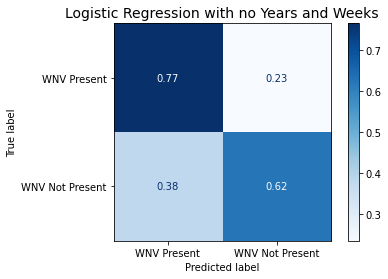

In [360]:
model_metrics_logreg(logreg_noyr_nowk , Xsm_train2, ysm_train2, Xs_holdout2, y_holdout2, 
                     'Logistic Regression with no Years and Weeks')

In [361]:
summary_df

,model,best_score,train_score,holdout_score,sensitivity,specificity,precision,f1_score,best_params
0,Logistic Regression no SMOTE,,0.945,0.944,0.096,0.766,0.139,0.158,
1,Logistic Regression with SMOTE,,0.860,0.789,0.640,0.766,0.139,0.250,
2,Logistic Regression with no Years and Weeks,,0.828,0.758,0.623,0.766,0.139,0.220,


## TO CHANGE

Previously, accuracy was 0.7958, sensitivity was 0.6316, specificity  was 0.8053, precision was 0.1586, and f1 score was 0.2535.

Without weeks, our accuracy has dropped from 79.6% to 77.3%, but our sensitivity has increased to about 65.8% compared to 63.2%.

Given that the values are rather similar, we would be inclined to drop the weeks so that we can generalise our results to years where the weather patterns are not similar for the weeks within. Using weather data would be a better model to account for any climate changes or erratic weather.

#### Changing the data to that where weeks and years are removed

In [362]:
df = df2.copy()

In [363]:
# Split into train and test (kaggle) data 
train = df[df['dataset']=='train'].copy()
test = df[df['dataset']=='test'].copy()
print(train.shape)
print(test.shape)

(8304, 214)
(43035, 214)


In [364]:
train.drop(columns='dataset', inplace=True)
test.drop(columns='dataset', inplace=True)

In [365]:
# Split train data into X (all features except wnvpresent) and y (wnvpresent)
features = [col for col in train.columns if col != 'wnvpresent']
X = train[features]
y = train['wnvpresent']

In [366]:
# Further split train data into train and holdout data
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, 
    y,
    stratify = y,
    random_state=42
)

In [367]:
# Scale our data
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_holdout = ss.transform(X_holdout)

In [368]:
# create synthetic data for train set
sm = SMOTE()
Xsm_train, ysm_train = sm.fit_resample(Xs_train, y_train)

### Logistic Regression with Regularization (GridSearchCV)

In [369]:
parameters = {'C': [0.001, 0.01],
              'class_weight': [None, 'balanced'],
              'penalty': ['l1', 'l2']}

# We are testing l1 and l2 penalties in GridSearch.
lr = LogisticRegression(solver = 'liblinear', 
                        max_iter = 1000,
                        random_state = 42)

gs = GridSearchCV(estimator = lr,                                    
                          param_grid = parameters,                           
                          scoring = 'recall',                               
                          cv = 5).fit(Xsm_train, ysm_train)    

The best parameters are used as below.

In [371]:
log_reg_regularisation = LogisticRegression(solver = 'liblinear', 
                           max_iter = 1000,
                           C = 0.001,
                           class_weight = None,
                           penalty = 'l2',
                           random_state = 42)

In [372]:
log_reg_regularisation.fit(X = Xsm_train,y = ysm_train)

LogisticRegression(C=0.001, max_iter=1000, random_state=42, solver='liblinear')

In [373]:
print(log_reg_regularisation.score(Xsm_train, ysm_train))
print(log_reg_regularisation.score(Xs_holdout, y_holdout))

0.8077315208156329
0.7138728323699421


In [374]:
df_col = df.drop(columns = ['wnvpresent', 'dataset'])

In [375]:
log_reg_regularisation_coef = pd.DataFrame(data=log_reg_regularisation.coef_[0],
                          index=df_col.columns,
                          columns=['coef'])

In [376]:
# Display Coefficients
coefs = pd.DataFrame({'variable':X.columns,
                            'coef':log_reg_regularisation.coef_[0],
                            'abs_coef':np.abs(log_reg_regularisation.coef_[0])
                     })


In [377]:
coefs.sort_values('abs_coef', inplace=True, ascending=False)
coefs_top40 = coefs.head(40).sort_values('coef', inplace=False, ascending=False)
coefs_top40

,variable,coef,abs_coef
176,trap_T900,0.281112,0.281112
2,tavg,0.243543,0.243543
24,dayofweek_3,0.206452,0.206452
117,trap_T115,0.154124,0.154124
162,trap_T225,0.140977,0.140977
180,codesum_BR HZ,0.140905,0.140905
196,codesum_TS TSRA RA,0.135763,0.135763
197,codesum_TS TSRA RA BR,0.128323,0.128323
31,trap_T003,0.119328,0.119328
28,trap_T002,0.109451,0.109451


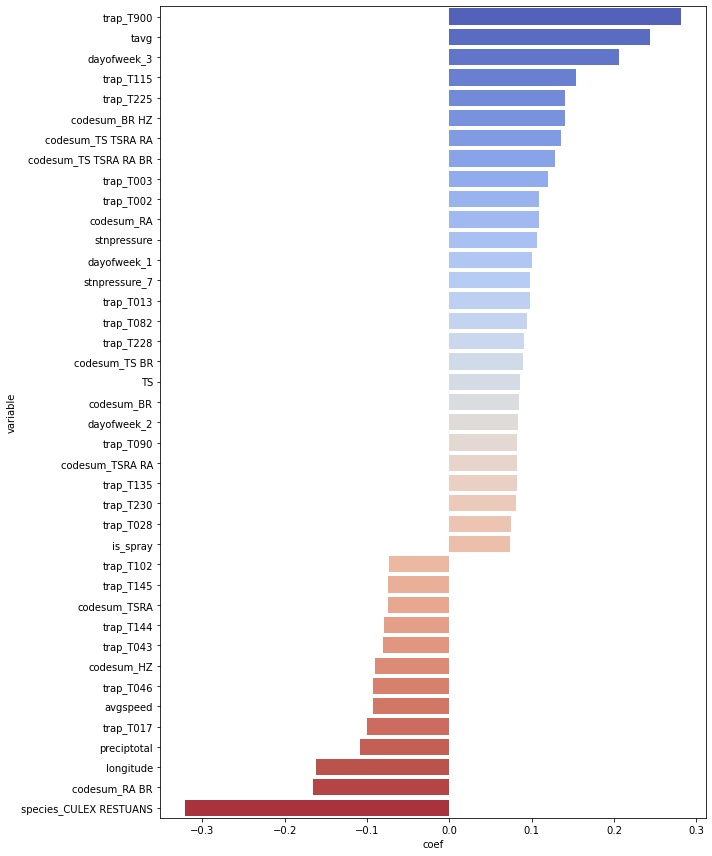

In [378]:
plt.figure(figsize=(10, 12))
sns.barplot(data=coefs_top40, y="variable", x='coef', orient='h', palette='coolwarm')
plt.tight_layout()

#plt.savefig(fname='./assets/final_model', dpi=300)

In [379]:
log_reg_regularisation_coef_0 = log_reg_regularisation_coef.loc[log_reg_regularisation_coef['coef'] == 0, :]
log_reg_regularisation_coef_0 

,coef
BCFG,0.0
trap_T002A,0.0
trap_T002B,0.0
trap_T065A,0.0
trap_T090A,0.0
trap_T090B,0.0
trap_T090C,0.0
trap_T128A,0.0
trap_T200A,0.0
trap_T200B,0.0


C:\Users\Asus\anaconda3\envs\dsi\envs\dsi27tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


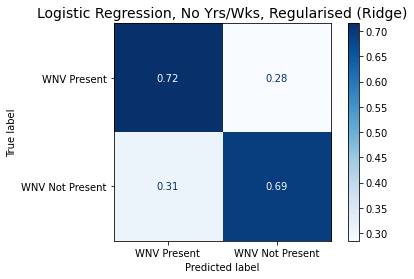

In [380]:
model_metrics_logreg(log_reg_regularisation, Xsm_train, ysm_train, Xs_holdout, y_holdout,'Logistic Regression, No Yrs/Wks, Regularised (Ridge)')

In [381]:
summary_df

,model,best_score,train_score,holdout_score,sensitivity,specificity,precision,f1_score,best_params
0,Logistic Regression no SMOTE,,0.945,0.944,0.096,0.766,0.139,0.158,
1,Logistic Regression with SMOTE,,0.860,0.789,0.640,0.766,0.139,0.250,
2,Logistic Regression with no Years and Weeks,,0.828,0.758,0.623,0.766,0.139,0.220,
3,"Logistic Regression, No Yrs/Wks, Regularised (...",,0.808,0.714,0.693,0.766,0.139,0.210,


### Random Forest

In [100]:
rf = RandomForestClassifier(n_estimators=100)

In [101]:
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7],
    'max_features': ['sqrt', 'log2', 0.5,0.7],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [3, 4, 5],
    'ccp_alpha': [0, 0.01, 0.1, 1],
}

In [102]:
gs_rf_0 = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs = -1)

In [103]:
gs_rf_0.fit(Xsm_train, ysm_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0], 'max_depth': [7],
                         'max_features': [0.5], 'min_samples_leaf': [3],
                         'min_samples_split': [10], 'n_estimators': [150]})

In [104]:
print(gs_rf_0.best_score_)
gs_rf_0.best_params_

0.915802888700085


{'ccp_alpha': 0,
 'max_depth': 7,
 'max_features': 0.5,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 150}

In [105]:
gs_rf_0.best_estimator_[0]

DecisionTreeClassifier(ccp_alpha=0, max_depth=7, max_features=0.5,
                       min_samples_leaf=3, min_samples_split=10,
                       random_state=1105681803)

In [108]:
feature_names = gs_rf_0.best_estimator_[0].feature_names_in_

AttributeError: 'DecisionTreeClassifier' object has no attribute 'feature_names_in_'

In [109]:
importances = gs_rf_0.best_estimator_[1].feature_importances_

In [110]:
rf_params2 = {
    'n_estimators': [150],
    'max_depth': [7, 9,'none'],
    'max_features': [0.4,0.5, 0.6],
    'min_samples_split': [10],
    'min_samples_leaf': [1,2,3],
    'ccp_alpha': [0],
}

In [111]:
gs_rf_1 = GridSearchCV(rf, param_grid=rf_params2, cv=5, n_jobs = -1)

In [112]:
gs_rf_1.fit(Xsm_train, ysm_train)

C:\Users\deang\anaconda3\envs\dsi27tf\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\deang\anaconda3\envs\dsi27tf\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\deang\anaconda3\envs\dsi27tf\lib\site-packages\sklearn\ensemble\_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "C:\Users\deang\anaconda3\envs\dsi27tf\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0], 'max_depth': [7, 9, 'none'],
                         'max_features': [0.4, 0.5, 0.6],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [10], 'n_estimators': [150]})

In [113]:
print(gs_rf_1.best_score_)
gs_rf_1.best_params_

0.9399320305862362


{'ccp_alpha': 0,
 'max_depth': 9,
 'max_features': 0.5,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 150}

C:\Users\deang\anaconda3\envs\dsi27tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


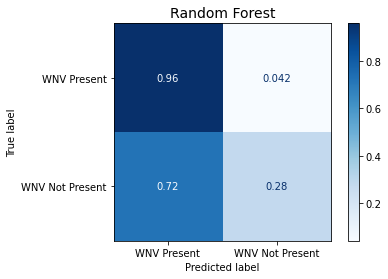

In [169]:
model_metrics(gs_rf_1, Xsm_train, ysm_train, Xs_holdout, y_holdout, 'Random Forest')

### Extra Trees

In [114]:
et = ExtraTreesClassifier(random_state=42)
et_params = {'n_estimators': [20, 25, 30, 35],
             'max_depth': [20, 30, 40, 50],
             'min_samples_leaf': [2, 3, 4],
            }

In [115]:
et_gs = GridSearchCV(et, 
                  param_grid=et_params, 
                  cv=5
                 )

In [116]:
et_gs.fit(Xsm_train, ysm_train);
et_gs.score(Xs_holdout, y_holdout)

0.9128131021194605

In [117]:
et_gs.best_estimator_

ExtraTreesClassifier(max_depth=50, min_samples_leaf=2, n_estimators=35,
                     random_state=42)

In [118]:
et_gs.best_params_

{'max_depth': 50, 'min_samples_leaf': 2, 'n_estimators': 35}

C:\Users\deang\anaconda3\envs\dsi27tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


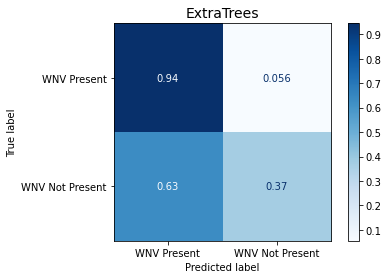

In [119]:
model_metrics(et_gs, Xsm_train, ysm_train, Xs_holdout, y_holdout, 'ExtraTrees')

### SVM

In [120]:
# C values to GridSearch over
svc_params = {
        'C': [10, 20, 30],
        'gamma':[0.01, 0.1], 
        'kernel' : ['rbf', 'sigmoid'],
        'probability': [True]
        }

In [121]:
# Instantiate and fit a gridsearch model
svc = SVC(max_iter=20000,
         verbose= 1)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scv_gs = GridSearchCV(svc, svc_params, cv=cv)
scv_gs.fit(Xsm_train, ysm_train);
scv_gs.score(Xs_holdout, y_holdout)


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

0.8998073217726397

In [122]:
scv_gs.best_estimator_

SVC(C=30, gamma=0.01, max_iter=20000, probability=True, verbose=1)

In [123]:
scv_gs.best_params_

{'C': 30, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True}

C:\Users\deang\anaconda3\envs\dsi27tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


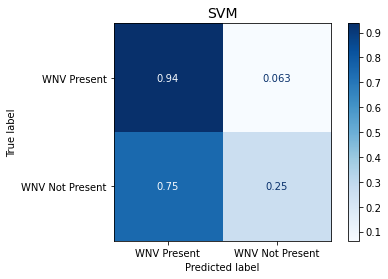

In [124]:
model_metrics(scv_gs, Xsm_train, ysm_train, Xs_holdout, y_holdout, 'SVM')

### AdaBoostClassifier

In [125]:
ada = AdaBoostClassifier(
    n_estimators = 100,
    learning_rate = 0.9
    # in general, if n_estimators is high, then learning_rate should be low
    # but we can use GridSearchCV
)
ada.fit(Xsm_train, ysm_train)
ada.score(Xs_holdout, y_holdout)

0.9113680154142582

In [126]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
ada_params = {
    'n_estimators': [50, 100, 150],
    'base_estimator__max_depth': [1,2],
    'learning_rate': [.8, .9, 1.]
    # you can also tune by all hyperparameters of DecisionTree
}
ada_gs = GridSearchCV(
    ada, 
    param_grid=ada_params, 
    cv=5
)
ada_gs.fit(Xsm_train, ysm_train)
ada_gs.score(Xs_holdout, y_holdout)

0.9229287090558767

In [127]:
tn, fp, fn, tp = confusion_matrix(y_holdout, ada_gs.predict(Xs_holdout)).ravel()

In [128]:
sensitivity = tp / (tp + fn)
sensitivity

0.14912280701754385

In [129]:
precision = tp / (tp + fp)
precision

0.2125

C:\Users\deang\anaconda3\envs\dsi27tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


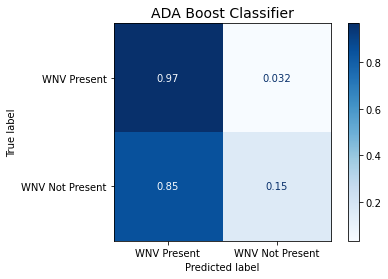

In [130]:
model_metrics(ada_gs, Xsm_train, ysm_train, Xs_holdout, y_holdout, 'ADA Boost Classifier')

In [131]:
summary_df

,model,best_score,train_score,holdout_score,sensitivity,specificity,precision,f1_score,best_params
0,ExtraTrees,0.956,0.997,0.834,0.368,0.944,0.278,0.317,"{'max_depth': 50, 'min_samples_leaf': 2, 'n_es..."
1,SVM,0.961,0.998,0.704,0.254,0.937,0.191,0.218,"{'C': 30, 'gamma': 0.01, 'kernel': 'rbf', 'pro..."
2,ADA Boost Classifier,0.954,0.997,0.735,0.149,0.968,0.212,0.175,"{'base_estimator__max_depth': 2, 'learning_rat..."


In [132]:
print(ada_gs.best_score_)
ada_gs.best_params_

0.9538657604078166


{'base_estimator__max_depth': 2, 'learning_rate': 0.8, 'n_estimators': 150}

<AxesSubplot:>

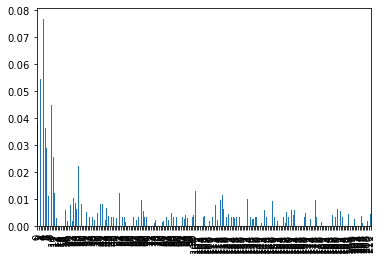

In [133]:
pd.Series(ada_gs.best_estimator_.feature_importances_).plot.bar()

### Gradient Boosting Classifier

In [134]:
gboost = GradientBoostingClassifier()
gboost_params = {
    'max_depth': [2, 3, 4],
    'n_estimators': [100, 125, 150],
    'learning_rate': [.08, .1, .12]
}
gb_gs = GridSearchCV(
    gboost, 
    param_grid=gboost_params, 
    cv=3
)
gb_gs.fit(Xsm_train, ysm_train)
gb_gs.score(Xs_holdout, y_holdout)

0.9368978805394991

In [135]:
print(gb_gs.best_score_)
gb_gs.best_params_

0.955909129610098


{'learning_rate': 0.12, 'max_depth': 4, 'n_estimators': 150}

In [136]:
#0.955	0.996	0.853	

In [137]:
tn, fp, fn, tp = confusion_matrix(y_holdout, gb_gs.predict(Xs_holdout)).ravel()

In [138]:
sensitivity = tp / (tp + fn)
sensitivity

0.14912280701754385

In [139]:
specificity = tn / (tn + fp)
specificity

0.9826707441386341

In [140]:
precision = tp / (tp + fp)
precision

0.3333333333333333

In [141]:
confusion_matrix(y_holdout, gb_gs.predict(Xs_holdout))

array([[1928,   34],
       [  97,   17]], dtype=int64)

C:\Users\deang\anaconda3\envs\dsi27tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


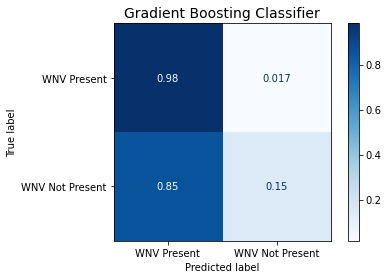

In [142]:
model_metrics(gb_gs, Xsm_train, ysm_train, Xs_holdout, y_holdout, 'Gradient Boosting Classifier')

In [143]:
summary_df

,model,best_score,train_score,holdout_score,sensitivity,specificity,precision,f1_score,best_params
0,ExtraTrees,0.956,0.997,0.834,0.368,0.944,0.278,0.317,"{'max_depth': 50, 'min_samples_leaf': 2, 'n_es..."
1,SVM,0.961,0.998,0.704,0.254,0.937,0.191,0.218,"{'C': 30, 'gamma': 0.01, 'kernel': 'rbf', 'pro..."
2,ADA Boost Classifier,0.954,0.997,0.735,0.149,0.968,0.212,0.175,"{'base_estimator__max_depth': 2, 'learning_rat..."
3,Gradient Boosting Classifier,0.956,0.995,0.841,0.149,0.983,0.333,0.206,"{'learning_rate': 0.12, 'max_depth': 4, 'n_est..."


### Neural Network

In [147]:
def model_metrics_nn(model, modelname):
    '''Generates confusion matrix and adds scores to summary_df'''
    #Generate confusion matrix
    tn, fp, fn, tp = confusion_matrix(ysm_train, model.predict_classes(Xsm_train)).ravel();
    acc_train = (tn + tp) / (tn + fp + fn + tp)

    y_pred = model.predict_classes(Xs_holdout)
    confusion_matrix(y_holdout, # True values.
                     y_pred)  # Predicted values.
    tn, fp, fn, tp = confusion_matrix(y_holdout, y_pred).ravel();
    acc = (tn + tp) / (tn + fp + fn + tp)
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    f1_score = 2 * (prec*sens) / (prec + sens)


    summary_df_rows = summary_df.shape[0]
    # Adding the scores into summary_df
    summary_df.loc[summary_df_rows] = [
        modelname,
        '',
        round(acc_train,3), # accuracy of train
        round(acc,3), # accuracy of holdout
        round(sens,3), # sensitivity of holdout
        round(spec,3), # specificity of holdout
        round(prec,3), # specificity of holdout
        round(f1_score,3), # f1 score of holdout
        '',
    ]

In [152]:
model = Sequential()
model.add(Dense(64,
                input_shape=(212,),
                activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [153]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [154]:
Xsm_train.shape

(11770, 212)

In [155]:
history = model.fit(Xsm_train, ysm_train, validation_data=(Xs_holdout, y_holdout), epochs=2, batch_size=512, verbose=0)

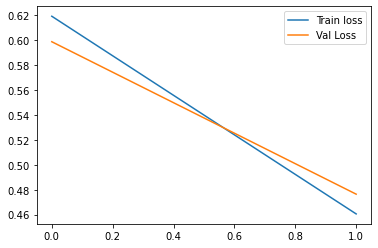

In [156]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend();

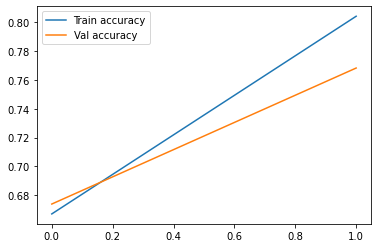

In [157]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.legend();

In [158]:
model_metrics_nn(model, 'Neural Network')

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [159]:
summary_df

,model,best_score,train_score,holdout_score,sensitivity,specificity,precision,f1_score,best_params
0,ExtraTrees,0.956,0.997,0.834,0.368,0.944,0.278,0.317,"{'max_depth': 50, 'min_samples_leaf': 2, 'n_es..."
1,SVM,0.961,0.998,0.704,0.254,0.937,0.191,0.218,"{'C': 30, 'gamma': 0.01, 'kernel': 'rbf', 'pro..."
2,ADA Boost Classifier,0.954,0.997,0.735,0.149,0.968,0.212,0.175,"{'base_estimator__max_depth': 2, 'learning_rat..."
3,Gradient Boosting Classifier,0.956,0.995,0.841,0.149,0.983,0.333,0.206,"{'learning_rate': 0.12, 'max_depth': 4, 'n_est..."
4,Neural Network,,0.826,0.768,0.605,0.778,0.137,0.223,


### Neural Network with Dropout

In [160]:
Xsm_train.shape[1]

212

In [161]:
# the turn-on and off are during each mini-batch run
model_dropout = Sequential()

n_input = Xsm_train.shape[1]
n_hidden = n_input

model_dropout.add(Dense(n_hidden, input_dim=n_input, activation='relu'))
model_dropout.add(Dropout(0.2))
model_dropout.add(Dense(64, activation='relu'))
model_dropout.add(Dropout(0.2))
model_dropout.add(Dense(1, activation='sigmoid'))

model_dropout.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# history = model.fit(Xsm_train, ysm_train, validation_data=(Xs_holdout, y_holdout), epochs=2, batch_size=512, verbose=0)
history_dropout = model_dropout.fit(
    Xsm_train,
    ysm_train,
    validation_data=(Xs_holdout, y_holdout), 
    epochs=1,
    batch_size=None
)

368/368 [==============================] - 1s 2ms/step - loss: 0.4306 - accuracy: 0.8009 - val_loss: 0.4123 - val_accuracy: 0.8141


In [162]:
model_metrics_nn(model_dropout, 'Neural Network with Dropout')

In [163]:
summary_df

,model,best_score,train_score,holdout_score,sensitivity,specificity,precision,f1_score,best_params
0,ExtraTrees,0.956,0.997,0.834,0.368,0.944,0.278,0.317,"{'max_depth': 50, 'min_samples_leaf': 2, 'n_es..."
1,SVM,0.961,0.998,0.704,0.254,0.937,0.191,0.218,"{'C': 30, 'gamma': 0.01, 'kernel': 'rbf', 'pro..."
2,ADA Boost Classifier,0.954,0.997,0.735,0.149,0.968,0.212,0.175,"{'base_estimator__max_depth': 2, 'learning_rat..."
3,Gradient Boosting Classifier,0.956,0.995,0.841,0.149,0.983,0.333,0.206,"{'learning_rate': 0.12, 'max_depth': 4, 'n_est..."
4,Neural Network,,0.826,0.768,0.605,0.778,0.137,0.223,
5,Neural Network with Dropout,,0.891,0.814,0.482,0.833,0.144,0.222,


### Neural Network with Early Stopping

In [164]:
# Build model using early stopping
model_es = Sequential()

n_input = Xsm_train.shape[1]

model_es.add(Dense(64, input_dim=n_input, activation='relu'))
model_es.add(Dense(1, activation='sigmoid'))

model_es.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

history_es = model_es.fit(
    Xsm_train,
    ysm_train,
    validation_data=(Xs_holdout, y_holdout),
    epochs=1,
    batch_size=None,
    callbacks=[early_stop]
)

368/368 [==============================] - 1s 2ms/step - loss: 0.4485 - accuracy: 0.7966 - val_loss: 0.4107 - val_accuracy: 0.8083


In [165]:
model_metrics_nn(model_es, 'Neural Network with Early Stopping')

In [171]:
summary_df

,model,best_score,train_score,holdout_score,sensitivity,specificity,precision,f1_score,best_params
0,ExtraTrees,0.956,0.997,0.834,0.368,0.944,0.278,0.317,"{'max_depth': 50, 'min_samples_leaf': 2, 'n_es..."
1,SVM,0.961,0.998,0.704,0.254,0.937,0.191,0.218,"{'C': 30, 'gamma': 0.01, 'kernel': 'rbf', 'pro..."
2,ADA Boost Classifier,0.954,0.997,0.735,0.149,0.968,0.212,0.175,"{'base_estimator__max_depth': 2, 'learning_rat..."
3,Gradient Boosting Classifier,0.956,0.995,0.841,0.149,0.983,0.333,0.206,"{'learning_rate': 0.12, 'max_depth': 4, 'n_est..."
4,Neural Network,,0.826,0.768,0.605,0.778,0.137,0.223,
5,Neural Network with Dropout,,0.891,0.814,0.482,0.833,0.144,0.222,
6,Neural Network with Early Stopping,,0.863,0.808,0.500,0.826,0.143,0.223,
7,Random Forest,0.94,0.991,0.795,0.281,0.958,0.281,0.281,"{'ccp_alpha': 0, 'max_depth': 9, 'max_features..."


In [173]:
summary_df.to_csv('../data/modelsummary1.csv')

### AUC-ROC Curve

C:\Users\deang\anaconda3\envs\dsi27tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\deang\anaconda3\envs\dsi27tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
C:\Users\deang\anaconda3\envs\dsi27tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve`

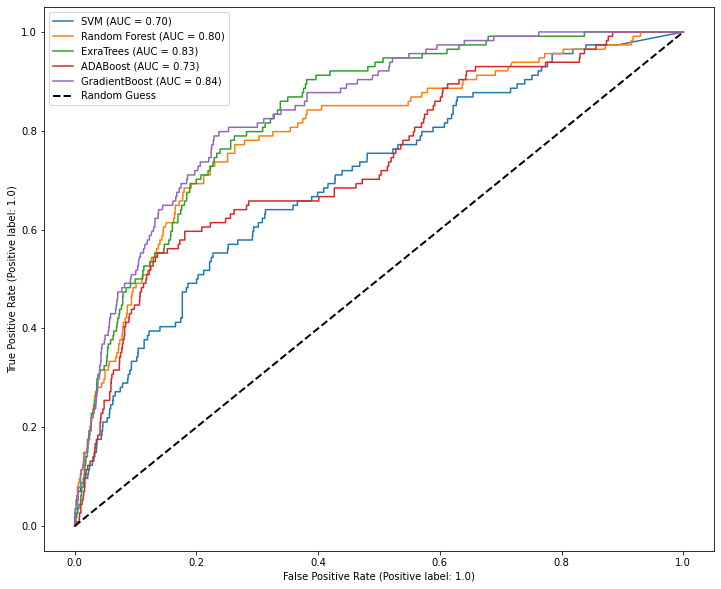

In [172]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
#plot_roc_curve(logreg, Xs_holdout, y_holdout, ax=ax, name='LogisticRegression')
plot_roc_curve(scv_gs, Xs_holdout, y_holdout, ax=ax, name='SVM')
plot_roc_curve(gs_rf_1, Xs_holdout, y_holdout, ax=ax, name='Random Forest')
plot_roc_curve(et_gs, Xs_holdout, y_holdout, ax=ax, name='ExtraTrees')
plot_roc_curve(ada_gs, Xs_holdout, y_holdout, ax=ax, name='ADABoost')
plot_roc_curve(gb_gs, Xs_holdout, y_holdout, ax=ax, name='GradientBoost')
#plot_roc_curve(model, Xs_holdout, y_holdout, ax=ax, name='Neural Network')
#plot_roc_curve(model_dropout, Xs_holdout, y_holdout, ax=ax, name='ADABoost')
#plot_roc_curve(model_es, Xs_holdout, y_holdout, ax=ax, name='GradientBoost')

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
plt.legend()